# Tune non-stationary algorithms

Here we create and save the data for tuning of non-stationary algorithms.
For tuning we use a subset (5000 points) of data similar to that used in experiment 7. But the costs don't change
in the tuning region. Saeed said it's the correct way to do tuning.

Also here we shuffle the dataset first.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


## Shuffle the data

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,pretentious,improper,completed,3,less_conv,inconv,problematic,not_recom,not_recom
1,pretentious,improper,completed,1,critical,convenient,nonprob,priority,spec_prior
2,usual,proper,completed,2,less_conv,inconv,problematic,priority,priority
3,great_pret,very_crit,completed,more,critical,inconv,nonprob,priority,spec_prior
4,usual,improper,foster,1,critical,convenient,slightly_prob,not_recom,not_recom
...,...,...,...,...,...,...,...,...,...
12955,great_pret,critical,foster,2,less_conv,inconv,slightly_prob,recommended,spec_prior
12956,pretentious,less_proper,complete,1,convenient,convenient,problematic,priority,priority
12957,pretentious,less_proper,complete,more,critical,convenient,problematic,not_recom,not_recom
12958,usual,proper,foster,more,critical,inconv,slightly_prob,not_recom,not_recom


In [9]:
df_num = df.astype('category')

In [10]:
df_num['final evaluation']

0         not_recom
1        spec_prior
2          priority
3        spec_prior
4         not_recom
            ...    
12955    spec_prior
12956      priority
12957     not_recom
12958     not_recom
12959    spec_prior
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [11]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,pretentious,improper,completed,3,less_conv,inconv,problematic,not_recom,not_recom
1,pretentious,improper,completed,1,critical,convenient,nonprob,priority,spec_prior
2,usual,proper,completed,2,less_conv,inconv,problematic,priority,priority
3,great_pret,very_crit,completed,more,critical,inconv,nonprob,priority,spec_prior
4,usual,improper,foster,1,critical,convenient,slightly_prob,not_recom,not_recom
...,...,...,...,...,...,...,...,...,...
12955,great_pret,critical,foster,2,less_conv,inconv,slightly_prob,recommended,spec_prior
12956,pretentious,less_proper,complete,1,convenient,convenient,problematic,priority,priority
12957,pretentious,less_proper,complete,more,critical,convenient,problematic,not_recom,not_recom
12958,usual,proper,foster,more,critical,inconv,slightly_prob,not_recom,not_recom


In [13]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [14]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,2,3,2,3,2,2,3,1,1
1,2,3,2,1,3,1,1,3,5
2,1,1,2,2,2,2,3,3,4
3,3,5,2,4,3,2,1,3,5
4,1,3,4,1,3,1,2,1,1
...,...,...,...,...,...,...,...,...,...
12955,3,4,4,2,2,2,2,2,5
12956,2,2,1,1,1,1,3,3,4
12957,2,2,1,4,3,1,3,1,1
12958,1,1,4,4,3,2,2,1,1


In [15]:
# Features are dropped according to their usefulness for the linear regression model.
# final evaluation is target variable

all_contexts = df_num.drop(['parents', 'has_nurs', 'social', 'social', 'final evaluation'], axis=1)

# For debug and testing drop some more columns
all_contexts = all_contexts.drop(['form'], axis=1).to_numpy()
# all_contexts = all_contexts.drop(['finance', 'form'], axis=1).to_numpy()

In [16]:
all_contexts.shape

(12960, 4)

In [17]:
all_contexts

array([[3, 2, 2, 1],
       [1, 3, 1, 3],
       [2, 2, 2, 3],
       ...,
       [4, 3, 1, 1],
       [4, 3, 2, 1],
       [3, 2, 2, 3]], dtype=int8)

In [18]:
y = df_num['final evaluation']

In [19]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [20]:
# Drop arms with small rewards

In [21]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [22]:
y[y == 2] = 4

In [23]:
y[y == 3] = 4

In [24]:
y.value_counts()

4    4596
1    4320
5    4044
Name: final evaluation, dtype: int64

In [25]:
np.sum(np.where(y == 3, 1, 0))

0

In [26]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [27]:
all_rewards

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [28]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4596, 4044])

In [29]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [30]:
all_rewards.shape[0]

12960

In [31]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, 11000),
    slice(11000, 12960),
]

In [32]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [33]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 11000, 12960]

In [34]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.33333333, 0.35462963, 0.31203704])

In [35]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [36]:
new_contexts.shape, new_rewards.shape

((12960, 4), (12960, 3))

## Plot expected reward

Min expected reward for arm 1: 0.284
Min expected reward for arm 2: 0.311
Min expected reward for arm 3: 0.29933333333333334


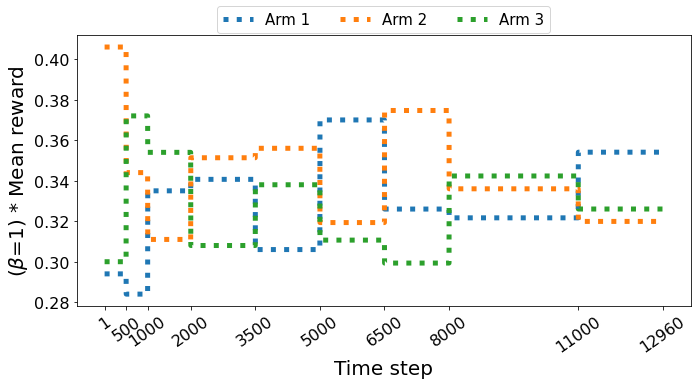

In [37]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


### Non-stationarity in costs

In [38]:
cost_change_points = [5000, 7000, 9000, 11000]
interval_count = len(cost_change_points) + 1

In [39]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [40]:
interval_means

[array([0.02121625, 0.01456818, 0.02644422, 0.01591205]),
 array([0.02410725, 0.02026431, 0.02171795, 0.01359217]),
 array([0.02470046, 0.01377241, 0.01226947, 0.02093359]),
 array([0.02418594, 0.01100072, 0.01138791, 0.02605358]),
 array([0.02618065, 0.01490609, 0.02230456, 0.0188636 ])]

In [41]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [42]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

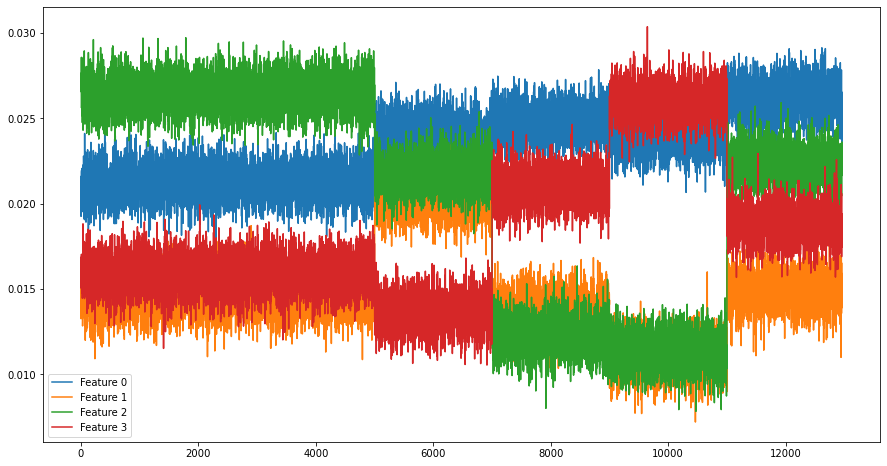

In [43]:
plot_costs(get_costs(), new_contexts.shape[0])

In [44]:
costs_obj = get_costs()

In [45]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [46]:
costs_vector.shape

(12960, 4)

## Plot expected reward minus sum of costs

In [47]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

Min expected gain for arm 1: 0.20036390834004436
Min expected gain for arm 2: 0.22660101957211043
Min expected gain for arm 3: 0.21403946509659832


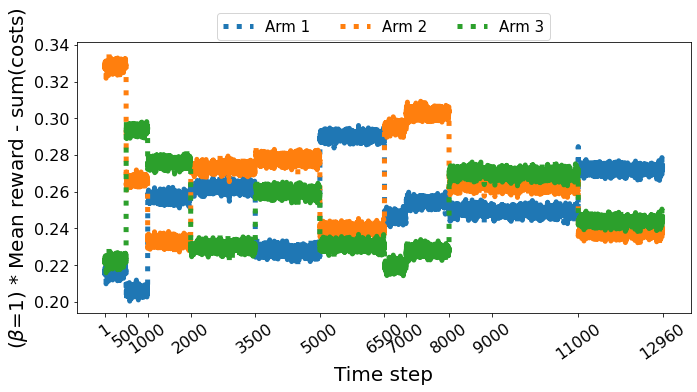

In [48]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = all_change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [49]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = all_change_point_values
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

# Save the data

In [50]:
data = (new_contexts, new_rewards, costs_vector)

In [51]:
import pickle

with open('dataset/nursery/nursery_preprocessed.pickle', 'wb') as f:
    pickle.dump(data, f)

## Tuning

In [52]:
TUNING_NUM_OF_TRIALS = 5000
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [53]:
np.random.seed(42)

### PS-LinUCB

In [54]:
ps_linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    for omega in [100, 300, 500, 750, 1000, 1250, 1500, 1750, 2000]:
        for delta in [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
            gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
            for i in range(NUM_REPETITIONS):

                ps_linucb = algorithms.PSLinUCB(
                    n_trials=TUNING_NUM_OF_TRIALS,
                    context_dimension=new_contexts.shape[1],
                    n_arms=new_rewards.shape[1],
                    alpha=alpha,
                    omega=omega,
                    delta=delta,
                )


                gain_pslinucb = evaluation.evaluate_on_synthetic_data(
                    ps_linucb,
                    new_contexts,
                    new_rewards,
                    costs_vector,
                    beta=BETA,
                    stop_after=TUNING_NUM_OF_TRIALS,
                )
                change_points = ps_linucb.change_points
                gains[i, :] = gain_pslinucb

            gain_pslinucb = np.mean(gains, axis=0)
            ps_linucb_gains[(alpha, omega, delta)] = gain_pslinucb

PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 2129.1955076837103
	Total reward: 2520.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 2129.1955076837103
	Total reward: 2520.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 2129.1955076837103
	Total reward: 2520.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 2129.1955076837103
	Total reward: 2520.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=100, delta=0.001)
Beta = 1
Total gain: 2129.1955076837103
	Total reward: 2520.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=100, delta=0.005)
Beta = 1
Total gain: 2129.1955076837103
	Total reward: 2520.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=100, 

PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 1517.1955076837105
	Total reward: 1908.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 1517.1955076837105
	Total reward: 1908.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=300, delta=0.01)
Beta = 1
Total gain: 1517.1955076837105
	Total reward: 1908.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 1514.1955076837105
	Total reward: 1905.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 1514.1955076837105
	Total reward: 1905.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=300, delta=0.03)
Beta = 1
Total gain: 1514.1955076837105
	Total reward: 1905.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=300, delta=

PSLinUCB (alpha=0.001, omega=500, delta=0.05)
Beta = 1
Total gain: 1510.1955076837098
	Total reward: 1901.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1458.195507683711
	Total reward: 1849.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1458.195507683711
	Total reward: 1849.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1458.195507683711
	Total reward: 1849.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1458.195507683711
	Total reward: 1849.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.001, omega=500, delta=0.1)
Beta = 1
Total gain: 1458.195507683711
	Total reward: 1849.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.001, omega=500, delta=0.15)
Beta

PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1252.19550768371
	Total reward: 1643.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1252.19550768371
	Total reward: 1643.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1252.19550768371
	Total reward: 1643.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=750, delta=0.2)
Beta = 1
Total gain: 1252.19550768371
	Total reward: 1643.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 1209.19550768371
	Total reward: 1600.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta = 1
Total gain: 1209.19550768371
	Total reward: 1600.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1000, delta=0.001)
Beta

PSLinUCB (alpha=0.001, omega=1250, delta=0.005)
Beta = 1
Total gain: 1223.1955076837098
	Total reward: 1614.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1250, delta=0.005)
Beta = 1
Total gain: 1223.1955076837098
	Total reward: 1614.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1223.1955076837098
	Total reward: 1614.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1223.1955076837098
	Total reward: 1614.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1223.1955076837098
	Total reward: 1614.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1250, delta=0.01)
Beta = 1
Total gain: 1223.1955076837098
	Total reward: 1614.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=125

PSLinUCB (alpha=0.001, omega=1500, delta=0.03)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500, delta=0.05)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1500,

PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=1750, delta=0.15)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.001, omega=1750, delta=0.2)
Beta = 1
Total gain: 1313.1955076837098
	Total reward: 1704.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.001, omega=1750, 

PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1853.195507683712
	Total reward: 2244.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1853.195507683712
	Total reward: 2244.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1853.195507683712
	Total reward: 2244.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.001)
Beta = 1
Total gain: 1853.195507683712
	Total reward: 2244.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 1853.195507683712
	Total reward: 2244.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=0.005)
Beta = 1
Total gain: 1853.195507683712
	Total reward: 2244.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=100, delta=

PSLinUCB (alpha=0.005, omega=300, delta=0.01)
Beta = 1
Total gain: 1982.1955076837123
	Total reward: 2373.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=0.01)
Beta = 1
Total gain: 1982.1955076837123
	Total reward: 2373.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 1947.1955076837116
	Total reward: 2338.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 1947.1955076837116
	Total reward: 2338.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 1947.1955076837116
	Total reward: 2338.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=0.03)
Beta = 1
Total gain: 1947.1955076837116
	Total reward: 2338.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=300, delta=

PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.005, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)
Beta = 1
Total gain: 1873.1955076837116
	Total reward: 2264.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.005, omega=500, delta=0.15)

PSLinUCB (alpha=0.005, omega=750, delta=0.2)
Beta = 1
Total gain: 1697.1955076837116
	Total reward: 2088.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=750, delta=0.2)
Beta = 1
Total gain: 1697.1955076837116
	Total reward: 2088.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=750, delta=0.2)
Beta = 1
Total gain: 1697.1955076837116
	Total reward: 2088.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1000, delta=0.001)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1000, de

PSLinUCB (alpha=0.005, omega=1250, delta=0.005)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.005)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1250, delta=0.01)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=125

PSLinUCB (alpha=0.005, omega=1500, delta=0.03)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1500, delta=0.05)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1500,

PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1750, delta=0.15)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.005, omega=1750, delta=0.2)
Beta = 1
Total gain: 1547.1955076837116
	Total reward: 1938.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.005, omega=1750, 

PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 2325.195507683715
	Total reward: 2716.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 2325.195507683715
	Total reward: 2716.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 2325.195507683715
	Total reward: 2716.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.001)
Beta = 1
Total gain: 2325.195507683715
	Total reward: 2716.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.005)
Beta = 1
Total gain: 2331.1955076837135
	Total reward: 2722.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.005)
Beta = 1
Total gain: 2331.1955076837135
	Total reward: 2722.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=100, delta=0.005

PSLinUCB (alpha=0.01, omega=300, delta=0.01)
Beta = 1
Total gain: 1963.1955076837125
	Total reward: 2354.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=300, delta=0.01)
Beta = 1
Total gain: 1963.1955076837125
	Total reward: 2354.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
Beta = 1
Total gain: 1953.1955076837116
	Total reward: 2344.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
Beta = 1
Total gain: 1953.1955076837116
	Total reward: 2344.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
Beta = 1
Total gain: 1953.1955076837116
	Total reward: 2344.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
Beta = 1
Total gain: 1953.1955076837116
	Total reward: 2344.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=300, delta=0.03)
B

PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=500, delta=0.1)
Beta = 1
Total gain: 1744.1955076837119
	Total reward: 2135.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=500, delta=0.15)
Beta = 1
Total gain: 1873.1955076837116
	Total reward: 2264.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=500, delta=0.15)
Beta =

PSLinUCB (alpha=0.01, omega=750, delta=0.2)
Beta = 1
Total gain: 1700.1955076837116
	Total reward: 2091.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=750, delta=0.2)
Beta = 1
Total gain: 1700.1955076837116
	Total reward: 2091.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.01, omega=750, delta=0.2)
Beta = 1
Total gain: 1700.1955076837116
	Total reward: 2091.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1000, delta=0.001)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1000, delta=0.001)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1000, delta=0.001)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.01, omega=1000, delta=0.0

PSLinUCB (alpha=0.01, omega=1250, delta=0.005)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta=0.01)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1250, delta

PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1500, delta=0.05)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=1500, delta=0.1)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=1500, delta=0.1)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1500, delta=0.

PSLinUCB (alpha=0.01, omega=1750, delta=0.15)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=1750, delta=0.2)
Beta = 1
Total gain: 1546.1955076837116
	Total reward: 1937.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.01, omega=2000, delta=0.001

PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2131.195507683711
	Total reward: 2522.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2131.195507683711
	Total reward: 2522.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2131.195507683711
	Total reward: 2522.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.005)
Beta = 1
Total gain: 2131.195507683711
	Total reward: 2522.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.01)
Beta = 1
Total gain: 2339.195507683714
	Total reward: 2730.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.01)
Beta = 1
Total gain: 2339.195507683714
	Total reward: 2730.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=100, delta=0.01)
Bet

PSLinUCB (alpha=0.05, omega=300, delta=0.03)
Beta = 1
Total gain: 1952.1955076837116
	Total reward: 2343.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=300, delta=0.03)
Beta = 1
Total gain: 1952.1955076837116
	Total reward: 2343.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
Beta = 1
Total gain: 1946.1955076837125
	Total reward: 2337.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
Beta = 1
Total gain: 1946.1955076837125
	Total reward: 2337.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
Beta = 1
Total gain: 1946.1955076837125
	Total reward: 2337.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
Beta = 1
Total gain: 1946.1955076837125
	Total reward: 2337.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=300, delta=0.05)
B

PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1858.195507683712
	Total reward: 2249.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1858.195507683712
	Total reward: 2249.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1858.195507683712
	Total reward: 2249.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1858.195507683712
	Total reward: 2249.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=500, delta=0.15)
Beta = 1
Total gain: 1858.195507683712
	Total reward: 2249.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.05, omega=500, delta=0.2)
Beta = 1
Total gain: 1730.1955076837116
	Total reward: 2121.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.05, omega=500, delta=0.2)
Beta = 1

PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1000, delta=0.001)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.005)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, delta=0.005)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1000, delta=0.005)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1000, 

PSLinUCB (alpha=0.05, omega=1250, delta=0.01)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1250, delta=0.03)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1250, delta=

PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1500, delta=0.1)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1500, delta=0.15)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1500, delta=0.15)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1500, delta=0.15

PSLinUCB (alpha=0.05, omega=1750, delta=0.2)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=1750, delta=0.2)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=2000, delta=0.001)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=2000, delta=0.001)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.05, omega=2000, delta=0.001)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=2000, delta=0.001)
Beta = 1
Total gain: 1516.1955076837112
	Total reward: 1907.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.05, omega=2000, delt

PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 2293.1955076837125
	Total reward: 2684.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 2293.1955076837125
	Total reward: 2684.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 2293.1955076837125
	Total reward: 2684.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 2293.1955076837125
	Total reward: 2684.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.01)
Beta = 1
Total gain: 2293.1955076837125
	Total reward: 2684.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.03)
Beta = 1
Total gain: 2248.1955076837094
	Total reward: 2639.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.1, omega=100, delta=0.03)
Beta = 1

PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 2018.1955076837128
	Total reward: 2409.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 2018.1955076837128
	Total reward: 2409.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=300, delta=0.05)
Beta = 1
Total gain: 2018.1955076837128
	Total reward: 2409.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
Total gain: 2017.1955076837116
	Total reward: 2408.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
Total gain: 2017.1955076837116
	Total reward: 2408.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
Total gain: 2017.1955076837116
	Total reward: 2408.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.1, omega=300, delta=0.1)
Beta = 1
Tot

PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1787.195507683712
	Total reward: 2178.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1787.195507683712
	Total reward: 2178.0
	Total cost: 390.8044923162866
Execution time: 1.0s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1787.195507683712
	Total reward: 2178.0
	Total cost: 390.8044923162866
Execution time: 1.0s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1787.195507683712
	Total reward: 2178.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.1, omega=500, delta=0.2)
Beta = 1
Total gain: 1787.195507683712
	Total reward: 2178.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.1, omega=750, delta=0.001)
Beta = 1
Total gain: 1806.1955076837114
	Total reward: 2197.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=750, delta=0.001)
Beta = 1
Total g

PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1000, delta=0.005)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.01)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1000, delta=0.01)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=1000, delta=0.01)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1000, delta=0.01

PSLinUCB (alpha=0.1, omega=1250, delta=0.03)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.05)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1250, delta=0.1)
Be

PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.15)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.2)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.2)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.1, omega=1500, delta=0.2)
Beta

PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=2000, delta=0.001)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=2000, delta=0.005)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=2000, delta=0.005)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=2000, delta=0.005)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.1, omega=2000, delta=0.005)
Beta = 1
Total gain: 1614.1955076837116
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.1, omega=2000, delta=0

PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2105.19550768371
	Total reward: 2496.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2105.19550768371
	Total reward: 2496.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2105.19550768371
	Total reward: 2496.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2105.19550768371
	Total reward: 2496.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=100, delta=0.03)
Beta = 1
Total gain: 2105.19550768371
	Total reward: 2496.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=100, delta=0.05)
Beta = 1
Total gain: 2303.1955076837144
	Total reward: 2694.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=100, delta=0.05)
Beta = 1
Total gai

PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2042.1955076837116
	Total reward: 2433.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2042.1955076837116
	Total reward: 2433.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.2, omega=300, delta=0.1)
Beta = 1
Total gain: 2042.1955076837116
	Total reward: 2433.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.2, omega=300, delta=0.15)
Beta = 1
Total gain: 2051.1955076837116
	Total reward: 2442.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.2, omega=300, delta=0.15)
Beta = 1
Total gain: 2051.1955076837116
	Total reward: 2442.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.2, omega=300, delta=0.15)
Beta = 1
Total gain: 2051.1955076837116
	Total reward: 2442.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.2, omega=300, delta=0.15)
Beta = 1
To

PSLinUCB (alpha=0.2, omega=500, delta=0.2)
Beta = 1
Total gain: 1751.1955076837116
	Total reward: 2142.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1
Total gain: 1614.195507683712
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1
Total gain: 1614.195507683712
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1
Total gain: 1614.195507683712
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1
Total gain: 1614.195507683712
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=750, delta=0.001)
Beta = 1
Total gain: 1614.195507683712
	Total reward: 2005.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=750, delta=0.005)
Beta = 1

PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 1525.1955076837123
	Total reward: 1916.0
	Total cost: 390.8044923162866
Execution time: 1.1s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 1525.1955076837123
	Total reward: 1916.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 1525.1955076837123
	Total reward: 1916.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1000, delta=0.01)
Beta = 1
Total gain: 1525.1955076837123
	Total reward: 1916.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1000, delta=0.03)
Beta = 1
Total gain: 1525.1955076837123
	Total reward: 1916.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1000, delta=0.03)
Beta = 1
Total gain: 1525.1955076837123
	Total reward: 1916.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.2, omega=1000, delta=0.03)
B

PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1250, delta=0.05)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1250, delta=0.1)
Beta =

PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1500, delta=0.2)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=1750, delta=0.001)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=1750, delta=0.001)
Beta

PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.005)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=2000, delta=0.01)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=2000, delta=0.01)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.2, omega=2000, delta=0.01)
Beta = 1
Total gain: 1482.1955076837123
	Total reward: 1873.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.2, omega=2000, delta=0.01

PSLinUCB (alpha=0.3, omega=100, delta=0.03)
Beta = 1
Total gain: 2298.1955076837135
	Total reward: 2689.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1
Total gain: 2255.1955076837103
	Total reward: 2646.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1
Total gain: 2255.1955076837103
	Total reward: 2646.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1
Total gain: 2255.1955076837103
	Total reward: 2646.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1
Total gain: 2255.1955076837103
	Total reward: 2646.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.05)
Beta = 1
Total gain: 2255.1955076837103
	Total reward: 2646.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=100, delta=0.1)
Beta = 1


PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2037.195507683712
	Total reward: 2428.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2037.195507683712
	Total reward: 2428.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2037.195507683712
	Total reward: 2428.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=300, delta=0.15)
Beta = 1
Total gain: 2037.195507683712
	Total reward: 2428.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.3, omega=300, delta=0.2)
Beta = 1
Total gain: 2030.1955076837125
	Total reward: 2421.0
	Total cost: 390.8044923162866
Execution time: 1.0s
PSLinUCB (alpha=0.3, omega=300, delta=0.2)
Beta = 1
Total gain: 2030.1955076837125
	Total reward: 2421.0
	Total cost: 390.8044923162866
Execution time: 1.0s
PSLinUCB (alpha=0.3, omega=300, delta=0.2)
Beta = 1
Total 

PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Beta = 1
Total gain: 1668.1955076837116
	Total reward: 2059.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=750, delta=0.001)
Beta = 1
Total gain: 1668.1955076837116
	Total reward: 2059.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
Beta = 1
Total gain: 1669.1955076837116
	Total reward: 2060.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
Beta = 1
Total gain: 1669.1955076837116
	Total reward: 2060.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
Beta = 1
Total gain: 1669.1955076837116
	Total reward: 2060.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
Beta = 1
Total gain: 1669.1955076837116
	Total reward: 2060.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=750, delta=0.005)
B

PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 1535.1955076837119
	Total reward: 1926.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 1535.1955076837119
	Total reward: 1926.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 1535.1955076837119
	Total reward: 1926.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 1535.1955076837119
	Total reward: 1926.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.03)
Beta = 1
Total gain: 1535.1955076837119
	Total reward: 1926.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.05)
Beta = 1
Total gain: 1535.1955076837119
	Total reward: 1926.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1000, delta=0.05)
B

PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=1250, delta=0.1)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=1250, delta=0.15)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.15)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1250, delta=0.15)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1250, delta=0.15)
Beta

PSLinUCB (alpha=0.3, omega=1500, delta=0.2)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1750, delta=0.001)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.3, omega=1750, delta=0.0

PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=2000, delta=0.01)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=2000, delta=0.03)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.3, omega=2000, delta=0.03)
Beta = 1
Total gain: 1504.1955076837119
	Total reward: 1895.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.3, omega=2000, delta=0.03)
B

PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Beta = 1
Total gain: 2340.1955076837125
	Total reward: 2731.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=100, delta=0.05)
Beta = 1
Total gain: 2340.1955076837125
	Total reward: 2731.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 2414.195507683711
	Total reward: 2805.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 2414.195507683711
	Total reward: 2805.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 2414.195507683711
	Total reward: 2805.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 2414.195507683711
	Total reward: 2805.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total ga

PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Total gain: 2048.1955076837116
	Total reward: 2439.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Total gain: 2048.1955076837116
	Total reward: 2439.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Total gain: 2048.1955076837116
	Total reward: 2439.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.4, omega=300, delta=0.2)
Beta = 1
Total gain: 2048.1955076837116
	Total reward: 2439.0
	Total cost: 390.8044923162866
Execution time: 1.0s
PSLinUCB (alpha=0.4, omega=500, delta=0.001)
Beta = 1
Total gain: 1887.195507683713
	Total reward: 2278.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=500, delta=0.001)
Beta = 1
Total gain: 1887.195507683713
	Total reward: 2278.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=500, delta=0.001)
Beta = 1
To

PSLinUCB (alpha=0.4, omega=750, delta=0.005)
Beta = 1
Total gain: 1778.1955076837125
	Total reward: 2169.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.01)
Beta = 1
Total gain: 1778.1955076837125
	Total reward: 2169.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.01)
Beta = 1
Total gain: 1778.1955076837125
	Total reward: 2169.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.01)
Beta = 1
Total gain: 1778.1955076837125
	Total reward: 2169.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=750, delta=0.01)
Beta = 1
Total gain: 1778.1955076837125
	Total reward: 2169.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=750, delta=0.01)
Beta = 1
Total gain: 1778.1955076837125
	Total reward: 2169.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=750, delta=0.03)
Beta = 

PSLinUCB (alpha=0.4, omega=1000, delta=0.05)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1000, delta=0.05)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1000, delta=0.05)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 1.3s
PSLinUCB (alpha=0.4, omega=1000, delta=0.05)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=1000, delta=0.1)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1000, delta=0.1)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1000, delta=0.1)
Beta

PSLinUCB (alpha=0.4, omega=1250, delta=0.15)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1250, delta=0.15)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1250, delta=0.2)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.4, omega=1250, delta=0.2)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1250, delta=0.2)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1250, delta=0.2)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1250, delta=0.2)
Beta =

PSLinUCB (alpha=0.4, omega=1750, delta=0.005)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=1750, delta=0.005)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.005)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.005)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.005)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.01)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=1750, delta=0.

PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.4, omega=2000, delta=0.03)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=2000, delta=0.05)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=2000, delta=0.05)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=2000, delta=0.05)
Beta = 1
Total gain: 1607.1955076837125
	Total reward: 1998.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.4, omega=2000, delta=0.05)
B

PSLinUCB (alpha=0.5, omega=100, delta=0.1)
Beta = 1
Total gain: 2380.1955076837125
	Total reward: 2771.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=100, delta=0.15)
Beta = 1
Total gain: 2272.195507683712
	Total reward: 2663.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=100, delta=0.15)
Beta = 1
Total gain: 2272.195507683712
	Total reward: 2663.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.5, omega=100, delta=0.15)
Beta = 1
Total gain: 2272.195507683712
	Total reward: 2663.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.5, omega=100, delta=0.15)
Beta = 1
Total gain: 2272.195507683712
	Total reward: 2663.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.5, omega=100, delta=0.15)
Beta = 1
Total gain: 2272.195507683712
	Total reward: 2663.0
	Total cost: 390.8044923162866
Execution time: 0.9s
PSLinUCB (alpha=0.5, omega=100, delta=0.2)
Beta = 1
Total 

PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total gain: 1816.1955076837125
	Total reward: 2207.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total gain: 1816.1955076837125
	Total reward: 2207.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total gain: 1816.1955076837125
	Total reward: 2207.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=500, delta=0.001)
Beta = 1
Total gain: 1816.1955076837125
	Total reward: 2207.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=500, delta=0.005)
Beta = 1
Total gain: 1816.1955076837125
	Total reward: 2207.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=500, delta=0.005)
Beta = 1
Total gain: 1816.1955076837125
	Total reward: 2207.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=500, delta=0.005)
B

PSLinUCB (alpha=0.5, omega=750, delta=0.01)
Beta = 1
Total gain: 1849.1955076837116
	Total reward: 2240.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=750, delta=0.01)
Beta = 1
Total gain: 1849.1955076837116
	Total reward: 2240.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=750, delta=0.03)
Beta = 1
Total gain: 1849.1955076837116
	Total reward: 2240.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=750, delta=0.03)
Beta = 1
Total gain: 1849.1955076837116
	Total reward: 2240.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=750, delta=0.03)
Beta = 1
Total gain: 1849.1955076837116
	Total reward: 2240.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=750, delta=0.03)
Beta = 1
Total gain: 1849.1955076837116
	Total reward: 2240.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=750, delta=0.03)
Beta = 1

PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.7s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1000, delta=0.1)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1000, delta=0.15)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1000, delta=0.15)
Beta =

PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1250, delta=0.2)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1500, delta=0.001)


PSLinUCB (alpha=0.5, omega=1750, delta=0.005)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.5, omega=1750, delta=0.01)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.5, omega=1750, delta=0.03)


PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.5, omega=2000, delta=0.05)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.5, omega=2000, delta=0.1)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.5, omega=2000, delta=0.1)
Beta = 1
Total gain: 1640.1955076837116
	Total reward: 2031.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.5, omega=2000, delta=0.1)
Beta

PSLinUCB (alpha=0.6, omega=100, delta=0.15)
Beta = 1
Total gain: 2254.195507683711
	Total reward: 2645.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=100, delta=0.15)
Beta = 1
Total gain: 2254.195507683711
	Total reward: 2645.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 2231.195507683709
	Total reward: 2622.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 2231.195507683709
	Total reward: 2622.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 2231.195507683709
	Total reward: 2622.0
	Total cost: 390.8044923162866
Execution time: 1.7s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain: 2231.195507683709
	Total reward: 2622.0
	Total cost: 390.8044923162866
Execution time: 0.6s
PSLinUCB (alpha=0.6, omega=100, delta=0.2)
Beta = 1
Total gain

PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 1905.1955076837125
	Total reward: 2296.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 1905.1955076837125
	Total reward: 2296.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 1905.1955076837125
	Total reward: 2296.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 1905.1955076837125
	Total reward: 2296.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=500, delta=0.005)
Beta = 1
Total gain: 1905.1955076837125
	Total reward: 2296.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=500, delta=0.01)
Beta = 1
Total gain: 1905.1955076837125
	Total reward: 2296.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=500, delta=0.01)
Bet

PSLinUCB (alpha=0.6, omega=750, delta=0.03)
Beta = 1
Total gain: 1868.195507683712
	Total reward: 2259.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=750, delta=0.03)
Beta = 1
Total gain: 1868.195507683712
	Total reward: 2259.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=750, delta=0.03)
Beta = 1
Total gain: 1868.195507683712
	Total reward: 2259.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 1931.195507683712
	Total reward: 2322.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 1931.195507683712
	Total reward: 2322.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total gain: 1931.195507683712
	Total reward: 2322.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=750, delta=0.05)
Beta = 1
Total

PSLinUCB (alpha=0.6, omega=1000, delta=0.1)
Beta = 1
Total gain: 1696.1955076837123
	Total reward: 2087.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 1693.1955076837123
	Total reward: 2084.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 1693.1955076837123
	Total reward: 2084.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 1693.1955076837123
	Total reward: 2084.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 1693.1955076837123
	Total reward: 2084.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1000, delta=0.15)
Beta = 1
Total gain: 1693.1955076837123
	Total reward: 2084.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=1000, delta=0.2)
Bet

PSLinUCB (alpha=0.6, omega=1500, delta=0.001)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.6, omega=1500, delta=0.001)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1500, delta=0.001)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1500, delta=0.001)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1500, delta=0.005)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1500, delta=0.005)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1500, delta=0

PSLinUCB (alpha=0.6, omega=1750, delta=0.01)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1750, delta=0.01)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=1750, delta=0.03)
B

PSLinUCB (alpha=0.6, omega=2000, delta=0.1)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=2000, delta=0.1)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=2000, delta=0.1)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=2000, delta=0.1)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=2000, delta=0.1)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=2000, delta=0.15)
Beta = 1
Total gain: 1701.1955076837123
	Total reward: 2092.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.6, omega=2000, delta=0.15)
Beta =

PSLinUCB (alpha=0.7, omega=100, delta=0.2)
Beta = 1
Total gain: 2270.1955076837107
	Total reward: 2661.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.7, omega=100, delta=0.2)
Beta = 1
Total gain: 2270.1955076837107
	Total reward: 2661.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.7, omega=100, delta=0.2)
Beta = 1
Total gain: 2270.1955076837107
	Total reward: 2661.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
Total gain: 1959.195507683712
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
Total gain: 1959.195507683712
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
Total gain: 1959.195507683712
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=300, delta=0.001)
Beta = 1
T

PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Beta = 1
Total gain: 1948.195507683713
	Total reward: 2339.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Beta = 1
Total gain: 1948.195507683713
	Total reward: 2339.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Beta = 1
Total gain: 1948.195507683713
	Total reward: 2339.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Beta = 1
Total gain: 1948.195507683713
	Total reward: 2339.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.01)
Beta = 1
Total gain: 1948.195507683713
	Total reward: 2339.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Beta = 1
Total gain: 1912.195507683713
	Total reward: 2303.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=500, delta=0.03)
Beta = 1
Total

PSLinUCB (alpha=0.7, omega=750, delta=0.05)
Beta = 1
Total gain: 1924.1955076837125
	Total reward: 2315.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=750, delta=0.05)
Beta = 1
Total gain: 1924.1955076837125
	Total reward: 2315.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 1923.1955076837125
	Total reward: 2314.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 1923.1955076837125
	Total reward: 2314.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 1923.1955076837125
	Total reward: 2314.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Total gain: 1923.1955076837125
	Total reward: 2314.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.7, omega=750, delta=0.1)
Beta = 1
Tota

PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 1681.1955076837128
	Total reward: 2072.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 1681.1955076837128
	Total reward: 2072.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 1681.1955076837128
	Total reward: 2072.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 1681.1955076837128
	Total reward: 2072.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1000, delta=0.2)
Beta = 1
Total gain: 1681.1955076837128
	Total reward: 2072.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.001)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1250, delta=0.001)
Beta

PSLinUCB (alpha=0.7, omega=1500, delta=0.005)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.005)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1500, delta=0.01)

PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.05)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.1)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.1)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=1750, delta=0.1)
Beta

PSLinUCB (alpha=0.7, omega=2000, delta=0.15)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=2000, delta=0.15)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta = 1
Total gain: 1678.1955076837128
	Total reward: 2069.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.7, omega=2000, delta=0.2)
Beta =

PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2006.1955076837135
	Total reward: 2397.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2006.1955076837135
	Total reward: 2397.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2006.1955076837135
	Total reward: 2397.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.005)
Beta = 1
Total gain: 2006.1955076837135
	Total reward: 2397.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.01)
Beta = 1
Total gain: 2006.1955076837135
	Total reward: 2397.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.01)
Beta = 1
Total gain: 2006.1955076837135
	Total reward: 2397.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=300, delta=0.01)
Beta

PSLinUCB (alpha=0.8, omega=500, delta=0.03)
Beta = 1
Total gain: 1929.195507683712
	Total reward: 2320.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=500, delta=0.03)
Beta = 1
Total gain: 1929.195507683712
	Total reward: 2320.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total gain: 1930.195507683712
	Total reward: 2321.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total gain: 1930.195507683712
	Total reward: 2321.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total gain: 1930.195507683712
	Total reward: 2321.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total gain: 1930.195507683712
	Total reward: 2321.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=500, delta=0.05)
Beta = 1
Total

PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 1828.1955076837114
	Total reward: 2219.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 1828.1955076837114
	Total reward: 2219.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 1828.1955076837114
	Total reward: 2219.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 1828.1955076837114
	Total reward: 2219.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.8, omega=750, delta=0.15)
Beta = 1
Total gain: 1828.1955076837114
	Total reward: 2219.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=750, delta=0.2)
Beta = 1
Total gain: 1782.1955076837116
	Total reward: 2173.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.8, omega=750, delta=0.2)
Beta = 1
T

PSLinUCB (alpha=0.8, omega=1250, delta=0.001)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.001)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.001)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.005)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.005)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0.005)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1250, delta=0

PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.03)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.05)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1500, delta=0.05)
B

PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1750, delta=0.1)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1750, delta=0.15)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1750, delta=0.15)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1750, delta=0.15)
Beta = 1
Total gain: 1707.1955076837119
	Total reward: 2098.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.8, omega=1750, delta=0.15)
Beta

PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 2352.1955076837116
	Total reward: 2743.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 2352.1955076837116
	Total reward: 2743.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 2352.1955076837116
	Total reward: 2743.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 2352.1955076837116
	Total reward: 2743.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=100, delta=0.001)
Beta = 1
Total gain: 2352.1955076837116
	Total reward: 2743.0
	Total cost: 390.8044923162866
Execution time: 0.8s
PSLinUCB (alpha=0.9, omega=100, delta=0.005)
Beta = 1
Total gain: 2348.195507683712
	Total reward: 2739.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=100, delta=0.005)
Be

PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 1993.1955076837132
	Total reward: 2384.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 1993.1955076837132
	Total reward: 2384.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.01)
Beta = 1
Total gain: 1993.1955076837132
	Total reward: 2384.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.03)
Beta = 1
Total gain: 2078.195507683713
	Total reward: 2469.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.03)
Beta = 1
Total gain: 2078.195507683713
	Total reward: 2469.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.03)
Beta = 1
Total gain: 2078.195507683713
	Total reward: 2469.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=300, delta=0.03)
Beta = 1
To

PSLinUCB (alpha=0.9, omega=500, delta=0.05)
Beta = 1
Total gain: 1968.1955076837119
	Total reward: 2359.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 1959.1955076837119
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 1959.1955076837119
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.5s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 1959.1955076837119
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 1959.1955076837119
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=500, delta=0.1)
Beta = 1
Total gain: 1959.1955076837119
	Total reward: 2350.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=500, delta=0.15)
Beta = 1
Tota

PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 1713.1955076837114
	Total reward: 2104.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 1713.1955076837114
	Total reward: 2104.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 1713.1955076837114
	Total reward: 2104.0
	Total cost: 390.8044923162866
Execution time: 0.3s
PSLinUCB (alpha=0.9, omega=750, delta=0.2)
Beta = 1
Total gain: 1713.1955076837114
	Total reward: 2104.0
	Total cost: 390.8044923162866
Execution time: 0.4s
PSLinUCB (alpha=0.9, omega=1000, delta=0.001)
Beta = 1
Total gain: 1722.1955076837119
	Total reward: 2113.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.001)
Beta = 1
Total gain: 1722.1955076837119
	Total reward: 2113.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1000, delta=0.001)
Beta =

PSLinUCB (alpha=0.9, omega=1250, delta=0.005)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.01)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.01)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.01)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.01)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.01)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1250, delta=0.03)


PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.05)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.1)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.1)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1500, delta=0.1)
Beta

PSLinUCB (alpha=0.9, omega=1750, delta=0.15)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.15)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.2)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.2)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.2)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.2)
Beta = 1
Total gain: 1718.1955076837119
	Total reward: 2109.0
	Total cost: 390.8044923162866
Execution time: 0.2s
PSLinUCB (alpha=0.9, omega=1750, delta=0.2)
Beta =

In [55]:
last_gains = {k:v[-1] for k,v in ps_linucb_gains.items()}
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_alpha_ps_linucb, best_omega_ps_linucb, best_delta_ps_linucb

(0.4, 100, 0.1)

### Evaluate tuned

In [56]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_ps_linucb,
        omega=best_omega_ps_linucb,
        delta=best_delta_ps_linucb,
    )


    gain_pslinucb = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    change_points = ps_linucb.change_points
    gains[i, :] = gain_pslinucb

gain_pslinucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 6273.124896050875
	Total reward: 7273.0
	Total cost: 999.8751039491015
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 6273.124896050875
	Total reward: 7273.0
	Total cost: 999.8751039491015
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 6273.124896050875
	Total reward: 7273.0
	Total cost: 999.8751039491015
Execution time: 0.7s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 6273.124896050875
	Total reward: 7273.0
	Total cost: 999.8751039491015
Execution time: 0.8s
PSLinUCB (alpha=0.4, omega=100, delta=0.1)
Beta = 1
Total gain: 6273.124896050875
	Total reward: 7273.0
	Total cost: 999.8751039491015
Execution time: 0.8s
Average gain: 6273.124896050875


### Algorithm1 is tuned separately

Using script3 in cloud. This is because Algorithm1 is much more computationally demanding.

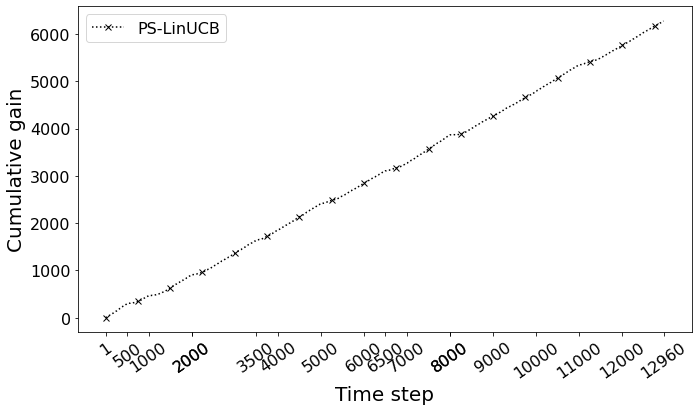

In [57]:
plot_gains({
    'PS-LinUCB': gain_pslinucb,
},
)
